In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

DATA_DIR = Path("./pistachio_1_data")
df = pd.read_csv(DATA_DIR / "all_dyads.csv")

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_31992/2407243207.py:7: DtypeWarning: Columns (36,66,67,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_DIR / "all_dyads.csv")


In [2]:
def prep_X_y(df: pd.DataFrame, response_column: str) -> tuple[pd.DataFrame, pd.Series]:
    X = df.drop(
        [
            "tantrum_within_60m",
            "tantrum_within_45m",
            "tantrum_within_30m",
            "tantrum_within_15m",
            # Useful for indexing
            "dyad",
        ],
        axis=1,
    )
    y = df[response_column].astype(int)
    return X, y


def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df["therapy_length_days"] = (
        pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])
    ).dt.days

    df["day_of_week"] = pd.to_datetime(df["ActivityDateTime"]).dt.dayofweek
    df["hour"] = pd.to_datetime(df["ActivityDateTime"]).dt.hour

    # Select features
    df = df.drop(
        [
            "ActivityDateTime",
            "DurationInSeconds",  # total active time
            "SleepMorningDate",
            "Diagnosis",
            "CDI start date",
            "PDI start date",
            "PDI end date",
            # "Medication ",
            "Type of medication",
            "Medication start date",
            "Week",
            "Therapy session",
            "Therapy Start",
            "Therapy End",
            "Education Status",
            "Parental Status",
            "Pre.ECBI",
            "Pre.ECBI.Prob",
            "Post.ECBI",
            "Post.ECBI.Prob",
            "QuitStudy",
            "Employment Status",
            "ParticipatingParent.Sex",
            "Parent-PhoneType",
            # Data that is only available as "real time data" (more battery use?) in Companion SDK
            # NOTE: Removing these actually improves model accuracy?
            "DistanceInMeters",
            "ActiveKilocalories",
            "METmins",
            "METavg",
            "activity_seconds_sedentary",
            "activity_seconds_active",
            "activity_seconds_highly_active",
        ]
        # moving window stats
        + [
            "hr_moving_avg_15m",
            "hr_moving_std_15m",
            "hr_moving_min_15m",
            "hr_moving_max_15m",
            "hr_moving_avg_30m",
            "hr_moving_std_30m",
            "hr_moving_min_30m",
            "hr_moving_max_30m",
            "hr_moving_avg_45m",
            "hr_moving_std_45m",
            "hr_moving_min_45m",
            "hr_moving_max_45m",
        ],
        axis=1,
    )
    df = df.drop([col for col in df.columns if col.startswith("hr-prev")], axis=1)

    def yn_to_bool(df):
        """
        Convert columns with 'Y'/'N' strings to boolean True/False.
        """
        for col in df.columns:
            if df[col].nunique() == 2 and set(df[col].dropna().unique()) == {"Y", "N"}:
                df[col] = df[col].map({"Y": True, "N": False})
        return df

    df = yn_to_bool(df)

    # Convert categorical columns to dummy variables
    df = pd.get_dummies(df, drop_first=True)

    return df

In [3]:
cleaned_dyads_df = clean_data(df)

df_train = cleaned_dyads_df[cleaned_dyads_df["Arm_Sham"]]
X_train, y_train = prep_X_y(df_train, "tantrum_within_60m")

df_test = cleaned_dyads_df[~cleaned_dyads_df["Arm_Sham"]]
X_test, y_test = prep_X_y(df_test, "tantrum_within_60m")

/var/folders/3f/rygbfpzx3l7fcpbc7540q88w0000gr/T/ipykernel_31992/2104635364.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


In [ ]:
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score

model = xgb.XGBClassifier()
model.fit(X_train, y_train)

threshold = 1e-4
y_pred_proba = model.predict_proba(X_test)
y_pred = (y_pred_proba[:, 1] >= threshold).astype(int)

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

F1 Score: 0.013602661067028413
Precision: 0.006913878761546744
Recall: 0.4178082191780822


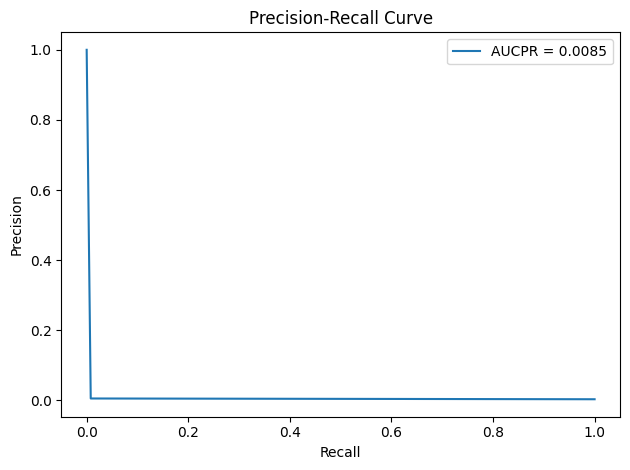

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, precision_recall_curve

# Compute precision-recall curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred)
aucpr = auc(recall_vals, precision_vals)

plt.figure()
plt.plot(recall_vals, precision_vals, label=f"AUCPR = {aucpr:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
from sklearn.base import BaseEstimator
from sklearn.metrics import f1_score, precision_score, recall_score


class SimpleModel(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        mean_hr = X["hr_moving_avg_60m"]
        return (mean_hr > 105) & (mean_hr < 129)


simple_model = SimpleModel()
df_test = cleaned_dyads_df[~cleaned_dyads_df["Arm_Sham"]]
X_test, y_test = prep_X_y(df_test, "tantrum_within_60m")

y_pred = simple_model.predict(X_test)

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

F1 Score: 0.00990084802915728
Precision: 0.005013441836808835
Recall: 0.3938356164383562
